In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ignore warnings:
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_theme(style='whitegrid')

In [2]:
class CallReports:
    def __init__(self, folder_path, essential_vars=None):
        """
        Initialize the analysis class with the folder path where 'call_reports.csv' is stored.
        
        Parameters:
          folder_path (str): Path to the folder containing 'call_reports.csv'.
          essential_vars (list, optional): List of columns that must always be included.
                Defaults to ['IDRSSD', 'Financial Institution Name', 'Date'].
        """
        self.folder_path = folder_path
        # Build full path for the call_reports.csv file.
        self.file_path = os.path.join(folder_path, "call_reports.csv")
        
        if essential_vars is None:
            self.essential_vars = ['IDRSSD', 'Financial Institution Name', 'Date']
        else:
            self.essential_vars = essential_vars
        
        # DataFrames will be loaded later, once variables to select are provided.
        self.df_selected = None
        self.df_constructed = None
        self.df_balanced = None

    def select_variables(self, variables=None):
        """
        Select a subset of columns for analysis and load only those columns from the CSV file.
        Essential variables are always included.
        
        Also, check for duplicate columns that come in pairs ending with '_x' and '_y'. For each pair,
        compute the maximum gap (absolute difference) between the entries. The maximum gap is printed,
        and if the gap is zero, the '_y' column is dropped (keeping the '_x' column).
        
        Finally, reorder the columns so that the essential variables (self.essential_vars)
        and the 'Year' column (if it exists) are the first columns in the DataFrame.
        
        Parameters:
        variables (list, optional): Additional variable names to include besides essential ones.
                                        If None, only essential variables will be selected.
        
        Returns:
        DataFrame with the selected (and cleaned) columns, with essential_vars and 'Year' ordered first.
        """
        # Combine the essential variables and any additional requested variables.
        if variables is None:
            vars_to_select = self.essential_vars.copy()
        else:
            vars_to_select = list(set(self.essential_vars + variables))
        
        # Read only the header of the CSV to know which columns exist.
        try:
            df_header = pd.read_csv(self.file_path, nrows=0)
        except Exception as e:
            raise IOError(f"Error reading file header from {self.file_path}: {e}")
        
        available_in_file = df_header.columns.tolist()
        
        # Warn if some requested variables are not in the file.
        missing_vars = [v for v in vars_to_select if v not in available_in_file]
        if missing_vars:
            print("Warning: The following variables are not in the data and will be skipped:", missing_vars)
        
        # Determine the final list of columns to load.
        available_vars = [v for v in vars_to_select if v in available_in_file]
        
        # Load only the selected columns from the CSV.
        self.df_selected = pd.read_csv(self.file_path, usecols=available_vars)
        
        # Ensure the 'Date' column is converted to datetime if present.
        if 'Date' in self.df_selected.columns:
            self.df_selected['Date'] = pd.to_datetime(self.df_selected['Date'], errors='coerce')
        
        # Check for duplicate variables that come with suffixes '_x' and '_y'.
        for col in self.df_selected.columns:
            if col.endswith("_x"):
                base = col[:-2]  # Remove the '_x' suffix
                col_y = base + "_y"
                if col_y in self.df_selected.columns:
                    try:
                        # Compute maximum absolute difference ("gap") between the two columns.
                        gap = (self.df_selected[col] - self.df_selected[col_y]).abs().max()
                    except Exception as e:
                        # If subtraction fails (e.g., non-numeric data), compare equality.
                        diff = self.df_selected[col] != self.df_selected[col_y]
                        gap = 0 if not diff.any() else "Mismatch"
                    
                    print(f"Duplicate variable {base}: max gap between {col} and {col_y} is {gap}")
                    
                    # If the gap is zero, drop the duplicate '_y' column.
                    if gap == 0:
                        print(f"Dropping duplicate column {col_y} as it is identical to {col}.")
                        self.df_selected.drop(columns=[col_y], inplace=True)
        
        # Reorder columns: ensure that the columns in essential_vars and 'Year'
        # are the first columns, followed by the rest in their original order.
        order_cols = []
        for col in self.essential_vars:
            if col in self.df_selected.columns:
                order_cols.append(col)
        if 'Year' in self.df_selected.columns:
            order_cols.append('Year')
        # Append any remaining columns that were not in order_cols.
        other_cols = [col for col in self.df_selected.columns if col not in order_cols]
        self.df_selected = self.df_selected[order_cols + other_cols]
        
        return self.df_selected
        
        
    def compare_variables(self, var_RCFD, var_RCON):
        """
        Compare two columns (e.g., a RCFD column and a RCON column).
        
        Returns:
          A dictionary with counts for:
            - both_valid: Observations where both are not NaN.
            - RCFD_only: Observations where only var_RCFD is not NaN.
            - RCON_only: Observations where only var_RCON is not NaN.
            - both_NaN: Observations where both are NaN.
          
        Note: This function requires that select_variables() has been run.
        """
        if self.df_selected is None:
            raise ValueError("Data has not been subset. Please run select_variables() first.")
        
        for var in [var_RCFD, var_RCON]:
            if var not in self.df_selected.columns:
                raise ValueError(f"Column {var} is not available in the selected DataFrame.")
        
        df_subset = self.df_selected[[var_RCFD, var_RCON]]
        both_valid = df_subset.dropna().shape[0]
        rcf_only = ((df_subset[var_RCFD].notna()) & (df_subset[var_RCON].isna())).sum()
        rcon_only = ((df_subset[var_RCON].notna()) & (df_subset[var_RCFD].isna())).sum()
        both_nan = ((df_subset[var_RCFD].isna()) & (df_subset[var_RCON].isna())).sum()
        
        return {
            "both_valid": both_valid,
            "RCFD_only": rcf_only,
            "RCON_only": rcon_only,
            "both_NaN": both_nan
        }

    def construct_definitions(self, mappings):
        """
        Construct new variables from pairs of existing columns based on provided mappings.
        
        Parameters:
        mappings (list): A list of dictionaries. Each dictionary should specify:
            - "first_col": Name of the first column.
            - "second_col": Name of the second column.
            - "new_var": Desired name for the new variable.
            Optional keys:
            - "mask_zeros": (bool) If True, replace zeros with NaN.
            - "apply_diff": (bool) If True, compute the difference over time.
            - "method": (str) Specifies how to combine the two columns when both are non-null.
                        Options are: "secondary", "first", "min", "max", "mean", or "sum".
                        Default is "secondary".
        
        Returns:
        A new DataFrame with the constructed variables appended.
        """
        if self.df_selected is None:
            raise ValueError("Data has not been subset. Please run select_variables() first.")
            
        new_df = self.df_selected.copy()
        
        for mapping_item in mappings:
            first_col = mapping_item.get("first_col")
            second_col = mapping_item.get("second_col")
            new_var = mapping_item.get("new_var")
            
            # Ensure the specified columns exist.
            for col in [first_col, second_col]:
                if col not in new_df.columns:
                    raise ValueError(f"Column {col} is not in the selected DataFrame.")
                    
            # Determine the method for combining the two columns.
            method = mapping_item.get("method", "secondary")
            if method == "min":
                new_df[new_var] = new_df[[first_col, second_col]].min(axis=1)
            elif method == "max":
                new_df[new_var] = new_df[[first_col, second_col]].max(axis=1)
            elif method == "mean":
                new_df[new_var] = new_df[[first_col, second_col]].mean(axis=1, skipna=True)
            elif method == "sum":
                new_df[new_var] = new_df[first_col].fillna(0) + new_df[second_col].fillna(0)
            elif method == "first":
                new_df[new_var] = new_df[first_col].combine_first(new_df[second_col])
            elif method == "secondary":
                new_df[new_var] = new_df[second_col].combine_first(new_df[first_col])
            else:
                raise ValueError(f"Unknown method provided: {method}")
            
            # Optionally mask zeros.
            if mapping_item.get("mask_zeros", False):
                new_df[new_var] = new_df[new_var].mask(new_df[new_var] == 0, np.nan)
            
            # Optionally apply differencing over time.
            if mapping_item.get("apply_diff", False):
                if "IDRSSD" not in new_df.columns or "Date" not in new_df.columns:
                    raise ValueError("Both 'IDRSSD' and 'Date' columns are required to compute differences.")
                new_df = new_df.sort_values("Date")
                new_df[new_var] = new_df.groupby("IDRSSD")[new_var].diff()
        
        self.df_constructed = new_df

        return new_df


    def create_balanced_panel(self, df_input=None):
        """
        Transform the given dataset (or the constructed dataset) into a balanced panel by retaining
        only banks (identified by 'IDRSSD') that appear in all dates.
        
        Parameters:
          df_input (DataFrame, optional): The DataFrame to convert. Defaults to using self.df_constructed.
        
        Returns:
          A balanced panel DataFrame.
        """
        if df_input is None:
            if self.df_constructed is None:
                raise ValueError("No constructed DataFrame available. Please run construct_definitions() first.")
            df_input = self.df_constructed
        
        if "IDRSSD" not in df_input.columns or "Date" not in df_input.columns:
            raise ValueError("Both 'IDRSSD' and 'Date' columns must be in the DataFrame for creating a balanced panel.")
        
        n_dates = df_input["Date"].nunique()
        valid_banks = df_input.groupby("IDRSSD")["Date"].nunique()[lambda x: x == n_dates].index
        balanced_df = df_input[df_input["IDRSSD"].isin(valid_banks)].copy()
        self.df_balanced = balanced_df
        return balanced_df

In [3]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/clean'

In [4]:
cr = CallReports(path)

In [5]:
# define maturity variables:
loans_mat_vars = [
                'RCONA564', 'RCONA565', 'RCONA566', 'RCONA567', 'RCONA568', 'RCONA569',     # used
                #'RCFDA564', 'RCFDA565', 'RCFDA566', 'RCFDA567', 'RCFDA568', 'RCFDA569',     # to be tested
                # ------------------------------------------------------------------------------------------------
                'RCFDA570', 'RCFDA571', 'RCFDA572', 'RCFDA573', 'RCFDA574', 'RCFDA575',     # used 
                #'RCONA570', 'RCONA571', 'RCONA572', 'RCONA573', 'RCONA574', 'RCONA575',     # to be tested  
                ]

securities_mat_vars = [
             # --------------------------------------  Treasuries  --------------------------------------
                'RCFDA549', 'RCFDA550', 'RCFDA551', 'RCFDA552', 'RCFDA553', 'RCFDA554',     # used
                'RCONA549', 'RCONA550', 'RCONA551', 'RCONA552', 'RCONA553', 'RCONA554',     # to be tested
            # --------------------------------------  MBS  --------------------------------------
                'RCFDA555', 'RCFDA556', 'RCFDA557', 'RCFDA558', 'RCFDA559', 'RCFDA560',     # used
                'RCONA555', 'RCONA556', 'RCONA557', 'RCONA558', 'RCONA559', 'RCONA560',     # to be tested
                ]


# define the list of variables that will be used
vars = [
             # ------------------------------------------------------------------------------------------------ 
            'Date', 'IDRSSD', 'Financial Institution Name',           # Identifier Variables
            'OCC Charter Number', 'FDIC Certificate Number', 'RSSD9048', 'RSSD9424',
             # ------------------------------------------------------------------------------------------------
            'RCON2170', 'RCFD2170',                                    # Total Assets
             # ------------------------------------------------------------------------------------------------
             'RCON2122', 'RCFD2122',                                   # Total Loans
             # ------------------------------------------------------------------------------------------------
             'RCON2200',  'RCFN2200',                                   # Total Deposits
             # ------------------------------------------------------------------------------------------------
             'RCONF045', 'RCONF046', 'RCONF047', 
             'RCONF048', 'RCONF049', 'RCONF050',
             'RCONF051', 'RCONF052',                                    # Uninsured Deposits
             # ------------------------------------------------------------------------------------------------
             'RCON3210', 'RCFD3210',                                    # Total Equity Capital
             'RCONB530', 'RCFDB530',                                    # AOCI
             # ------------------------------------------------------------------------------------------------
             'RCON1754', 'RCFD1754',                                    # HTM Securities Ammortized Cost
             'RCFD1754_x', 'RCFD1754_y', 'RCON1754_x', 'RCON1754_y',
             # ------------------------------------------------------------------------------------------------
             'RCON1771', 'RCFD1771',                                                # HTM Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCON1772', 'RCFD1772',                                                # AFS Securities Ammortized Cost
             # ------------------------------------------------------------------------------------------------
             'RCFD1773_x', 'RCFD1773_y', 'RCON1773',                    # AFS Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCON0010', 'RCFD0010',                                    # Cash and balances due from depository institutions                                                
             'RCON0071', 'RCON0081',                                    
             'RCFD0071', 'RCFD0081',                                    
             # ------------------------------------------------------------------------------------------------
             'RIAD4073', 'RIAD4200', 'RIAD4185', 'RIAD4180', 'RIAD4172',# Income Variables
             ] 

# create a list putting together 'vars', 'loans_mat_vars', and 'securities_mat_vars':
all_vars = vars + loans_mat_vars + securities_mat_vars

In [6]:
main = cr.select_variables(all_vars)

Duplicate variable RCFD1754: max gap between RCFD1754_x and RCFD1754_y is 0.0
Dropping duplicate column RCFD1754_y as it is identical to RCFD1754_x.
Duplicate variable RCFD1773: max gap between RCFD1773_x and RCFD1773_y is 0.0
Dropping duplicate column RCFD1773_y as it is identical to RCFD1773_x.
Duplicate variable RCON1754: max gap between RCON1754_x and RCON1754_y is 0.0
Dropping duplicate column RCON1754_y as it is identical to RCON1754_x.


In [7]:
#cr.df_selected.head(10)
# Matches the other file! 

In [8]:
#last_digits = sorted(list(set([var[-3:] for var in securities_mat_vars])))

#for x in last_digits:
#    print('---------------------------------------------------------------------------------')
#    print('For x = ', x)
#    vars = [
#    'RCFDA' + str(int(x)), 'RCONA' + str(int(x))
#    ]
#    print(cr.compare_variables(vars[0], vars[1]))
# Matches the other file!

In [9]:
#last_digits = sorted(list(set([var[-3:] for var in loans_mat_vars])))
#last_digits = [int(x) for x in last_digits]
#last_digits = [x for x in last_digits if x < 570]

#for x in last_digits:
#    print('---------------------------------------------------------------------------------')
#    vars = [
#    'RCFDA' + str(x+6), 'RCONA' + str(x)
#    ]
#    print(vars[0], vars[1])
#    print(cr.compare_variables(vars[0], vars[1]))

# Matches the other file!   

In [10]:
mappings = [
    # 1) Loans: Total Loans = RCON2122.combine_first(RCFD2122), then mask zeros.
    {
        "first_col": "RCON2122",
        "second_col": "RCON2122",
        "new_var": "Total Loans",
        "method": "secondary",   # Gives RCON2122 if available, else RCFD2122.
        "mask_zeros": True
    },
    # 2) Deposits: Create Total Deposits from RCON2200 (a simple copy) and mask zeros.
    {
        "first_col": "RCON2200",
        "second_col": "RCON2200",
        "new_var": "Total Deposits",
        "method": "secondary",   # Since both are the same, this simply copies RCON2200.
        "mask_zeros": True
    },
    # 3) Assets: Create Total Assets from RCON2170 and mask zeros.
    {
        "first_col": "RCFD2170",
        "second_col": "RCON2170",
        "new_var": "Total Assets",
        "method": "secondary",   # Since both are the same, this simply copies RCON2170.
        "mask_zeros": True
    },
    # 4) Equity Capital: Create Total Equity Capital from RCON3210 and RCFD3210 and mask zeros.
    {
        "first_col": "RCON3210",
        "second_col": "RCFD3210",
        "new_var": "Total Equity Capital",
        "method": "secondary",   # Since both are the same, this simply copies RCON3210.
        "mask_zeros": True
    },
    # 5) AOCI: Create AOCI from RCONB530 and RCFDB530 and mask zeros.
    {
        "first_col": "RCONB530",
        "second_col": "RCFDB530",
        "new_var": "AOCI",
        "method": "secondary",   # Since both are the same, this simply copies RCONB530.
        "mask_zeros": True
    },
    # Mapping 1: Create RCON1754_right = RCON1754_x.combine_first(RCON1754)
    {
        "first_col": "RCON1754",      # fallback column
        "second_col": "RCON1754_x",   # primary column
        "new_var": "RCON1754_right",
        "method": "secondary"
    },
    # Mapping 2: Create RCFD1754_right = RCFD1754_x.combine_first(RCFD1754)
    {
        "first_col": "RCFD1754",      # fallback column
        "second_col": "RCFD1754_x",   # primary column
        "new_var": "RCFD1754_right",
        "method": "secondary"
    },
    # Mapping 3: Create 1754_right from RCFD1754_right and RCON1754_right
    # This takes the row-wise minimum:
    {
        "first_col": "RCFD1754_right",
        "second_col": "RCON1754_right",
        "new_var": "1754_right",
        "method": "secondary"
    },
    # Mapping 4: create 1772_right from RCFD1772 and RCON1772:
    {
        "first_col": "RCFD1772",
        "second_col": "RCON1772",
        "new_var": "1772_right",
        "method": "secondary"
    },
    # Mapping 5: Create 'Securities AC' from 1754_right and 1772_right:
    {
        "first_col": "1754_right",
        "second_col": "1772_right",
        "new_var": "Securities AC",
        "method": "sum",
        "mask_zeros": True
    },
    # Mapping 6: Create 1773_right from RCON1773 and RCFD1773_x:
    {
        "first_col": "RCFD1773_x",
        "second_col": "RCON1773",
        "new_var": "1773_right",
        "method": "secondary"
    },
    # Mapping 7: Create 'Securities Booked' from 1773_right and 1754_right:
    {
        "first_col": "1773_right",
        "second_col": "1754_right",
        "new_var": "Securities Booked",
        "method": "sum",
        "mask_zeros": True
    },
    # Mapping 8: Create '1771_right' from RCON1771 and RCFD1771:
    {
        "first_col": "RCFD1771",
        "second_col": "RCON1771",
        "new_var": "1771_right",
        "method": "secondary"
    },
    # Mapping 9: Create 'Securities Fair Value' from 1771_right and 1773_right:
    {
        "first_col": "1771_right",
        "second_col": "1773_right",
        "new_var": "Securities FV",
        "method": "sum",
        "mask_zeros": True
    },
    # Mapping 10: 'Insured Deposit Accounts' from RCONF049 and RCONF045:
    {
        "first_col": "RCONF049",
        "second_col": "RCONF045",
        "new_var": "Insured Deposit Accounts",
        "method": "sum",
    },
    # Mapping 11: 'Number of Insured Deposit Accounts' from RCONF050 and RCONF046:
    {
        "first_col": "RCONF050",
        "second_col": "RCONF046",
        "new_var": "Number of Insured Deposit Accounts",
        "method": "sum",
    },
    # Mapping 12: 'Uninsured Deposit Accounts' from RCONF051 and RCONF047:
    {
        "first_col": "RCONF051",
        "second_col": "RCONF047",
        "new_var": "Uninsured Deposit Accounts",
        "method": "sum",
    },
    # Mapping 13: 'Number of Uninsured Deposit Accounts' from RCONF052 and RCONF048:
    {
        "first_col": "RCONF052",
        "second_col": "RCONF048",
        "new_var": "Number of Uninsured Deposit Accounts",
        "method": "sum",
    },
    ]
# Create all the new variables:
main = cr.construct_definitions(mappings=mappings)

In [11]:
# Create 'Insured Deposit Accounts' and 'Number of Insured Deposit Accounts'
main['Insured Deposit Accounts'] = main['RCONF045'] + main['RCONF049']
main['Number of Insured Deposit Accounts'] = main['RCONF046'] + main['RCONF050']

# Create 'Uninsured Deposit Accounts' and 'Number of Uninsured Deposit Accounts'
main['Uninsured Deposit Accounts'] = main['RCONF047'] + main['RCONF051']
main['Number of Uninsured Deposit Accounts'] = main['RCONF048'] + main['RCONF052']

# Correct insurance coverage threshold based on date:
main['Insurance Coverage'] = np.where(main['Date'] < pd.Timestamp('2010-03-01'), 100, 250)

# Recalculate 'Insured Deposits' considering coverage threshold:
main['Insured Deposits'] = (
    main['Insured Deposit Accounts'] +
    main['Number of Uninsured Deposit Accounts'] * main['Insurance Coverage']
)

# Recalculate 'Uninsured Deposits':
main['Uninsured Deposits'] = (
    main['Uninsured Deposit Accounts'] -
    main['Number of Uninsured Deposit Accounts'] * main['Insurance Coverage']
)

# Create 'Total Deposits 2':
main['Total Deposits 2'] = main['Insured Deposits'] + main['Uninsured Deposits']


In [12]:
main[main['IDRSSD']==802866][['Date', 'IDRSSD', 'Financial Institution Name', 'Insured Deposits', 
                              'Uninsured Deposits', 'Total Deposits 2', 'Total Deposits', 'RCFN2200']].sort_values('Date').tail(10)

,Date,IDRSSD,Financial Institution Name,Insured Deposits,Uninsured Deposits,Total Deposits 2,Total Deposits,RCFN2200
464396,2020-09-30,802866.0,SILICON VALLEY BANK,7853689.0,72464477.0,80318166.0,79186262.0,7078319.0
623764,2020-12-31,802866.0,SILICON VALLEY BANK,8248707.0,86519547.0,94768254.0,94768254.0,8425853.0
146893,2021-03-31,802866.0,SILICON VALLEY BANK,8805446.0,105932502.0,114737948.0,114737949.0,10513246.0
308707,2021-06-30,802866.0,SILICON VALLEY BANK,9281664.0,125102839.0,134384503.0,134384503.0,13085918.0
469396,2021-09-30,802866.0,SILICON VALLEY BANK,13140568.0,145685497.0,158826065.0,158825895.0,13460987.0
628711,2021-12-31,802866.0,SILICON VALLEY BANK,13140750.0,162237250.0,175378000.0,175378000.0,16053000.0
151809,2022-03-31,802866.0,SILICON VALLEY BANK,13737000.0,169065000.0,182802000.0,182802000.0,17612000.0
313592,2022-06-30,802866.0,SILICON VALLEY BANK,13802500.0,161164500.0,174967000.0,174957000.0,15196000.0
474258,2022-09-30,802866.0,SILICON VALLEY BANK,14087750.0,151293250.0,165381000.0,165341000.0,13537000.0
633518,2022-12-31,802866.0,SILICON VALLEY BANK,14183000.0,147399000.0,161582000.0,161479000.0,13899000.0


## Regional Banking Crisis (2023)

### Scatter plots

In [222]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 'Total Loans', 'Total Deposits', 'Total Assets', 'Uninsured Deposits',
           'RCFD1754_right', 'RCON1754_right', '1754_right', 'RCFD1772', 'RCON1772', '1772_right', 'AOCI', 'Total Equity Capital',
           'Securities AC', 'Securities Booked', 'Securities FV']].copy()

In [223]:
df = df[(df['Date']=='2019-03-31') | (df['Date']=='2021-12-31')]
df = df.sort_values(by=['IDRSSD', 'Date']).reset_index(drop=True)

In [224]:
# Get the total number of unique dates in the DataFrame
total_dates = df['Date'].nunique()

# Identify banks that appear in all dates
banks_all_dates = df.groupby('IDRSSD')['Date'].nunique() == total_dates
banks_to_keep = banks_all_dates[banks_all_dates].index

# Filter the DataFrame to keep only these banks
df = df[df['IDRSSD'].isin(banks_to_keep)].reset_index(drop=True)

In [225]:
failed_banks = [802866, 4114567, 3437483]

In [226]:
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', 'RCON1772', 'RCFD1772', '1772_right']].sort_values(by='Date')
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', 'RCON1754_right', 'RCFD1754_right', '1754_right']].sort_values(by='Date')
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', '1772_right', '1754_right', 'Securities AC']].sort_values(by='Date')
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', 'RCON2170', 'RCFD2170']].sort_values(by='Date')
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', 'RCON3210', 'RCFD3210']].sort_values(by='Date')
#main[main['IDRSSD']==4114567.0][['Date', 'IDRSSD', 'Financial Institution Name', 'RCONB530', 'RCFDB530']].sort_values(by='Date')

In [227]:
# compute the growth rate of 'Securities AC' and 'Total Loans', and 'Total Deposits':
df['Securities AC Growth'] = df.groupby('IDRSSD')['Securities AC'].pct_change(fill_method=None)
df['Securities FV Growth'] = df.groupby('IDRSSD')['Securities FV'].pct_change(fill_method=None)
df['Securities Growth'] = df.groupby('IDRSSD')['Securities Booked'].pct_change(fill_method=None)
df['Loans Growth'] = df.groupby('IDRSSD')['Total Loans'].pct_change(fill_method=None)
df['Deposits Growth'] = df.groupby('IDRSSD')['Total Deposits'].pct_change(fill_method=None)
df['Uninsured Deposits Growth'] = df.groupby('IDRSSD')['Uninsured Deposits'].pct_change(fill_method=None)
df['Equity Capital Growth'] = df.groupby('IDRSSD')['Total Equity Capital'].pct_change(fill_method=None)
df['AOCI Growth'] = df.groupby('IDRSSD')['AOCI'].pct_change(fill_method=None)

In [228]:
# Drop the rows with NaN values in the 'Securities AC Growth' column
df = df.dropna(subset=['Securities AC Growth', 'Securities FV Growth', 'Equity Capital Growth', 'AOCI Growth', 'Uninsured Deposits Growth',
                        'Securities Growth', 'Loans Growth', 'Deposits Growth', 'Total Assets'])

# show the top 20 banks with the highest growth rate in 'Securities AC Growth':
df.sort_values(by='Securities AC Growth', ascending=False, inplace=True)

In [234]:
test = df[['IDRSSD', 'Financial Institution Name', 'Total Assets', 'Deposits Growth', 'Securities AC Growth', 'Loans Growth']].head(100)
# take the minimum assets of test:
print(test['Total Assets'].min()*1000/10e5, test['Total Assets'].max()*1000/10e5)
print(test['Securities AC Growth'].min(), test['Securities AC Growth'].max())
test['Total Assets (Millions)'] = test['Total Assets'].apply(lambda x: x*1000/10e5)
outliers_securities = test[['IDRSSD', 'Financial Institution Name', 'Total Assets (Millions)', 'Deposits Growth', 'Securities AC Growth', 'Loans Growth']].head(100)['IDRSSD']

23.007 34726.171
5.666666666666667 1109.3047508690613


In [235]:
# exclude outliers_securities from the main DataFrame:
df2 = df[~df['IDRSSD'].isin(outliers_securities)].reset_index(drop=True)

In [236]:
print(df['Securities AC Growth'].quantile(0.99))
print(df2['Securities AC Growth'].quantile(0.99))

print(df['Deposits Growth'].quantile(0.99))
print(df2['Deposits Growth'].quantile(0.99))

10.784948639867743
4.395438094480749
2.2256118261467748
2.020695732084787


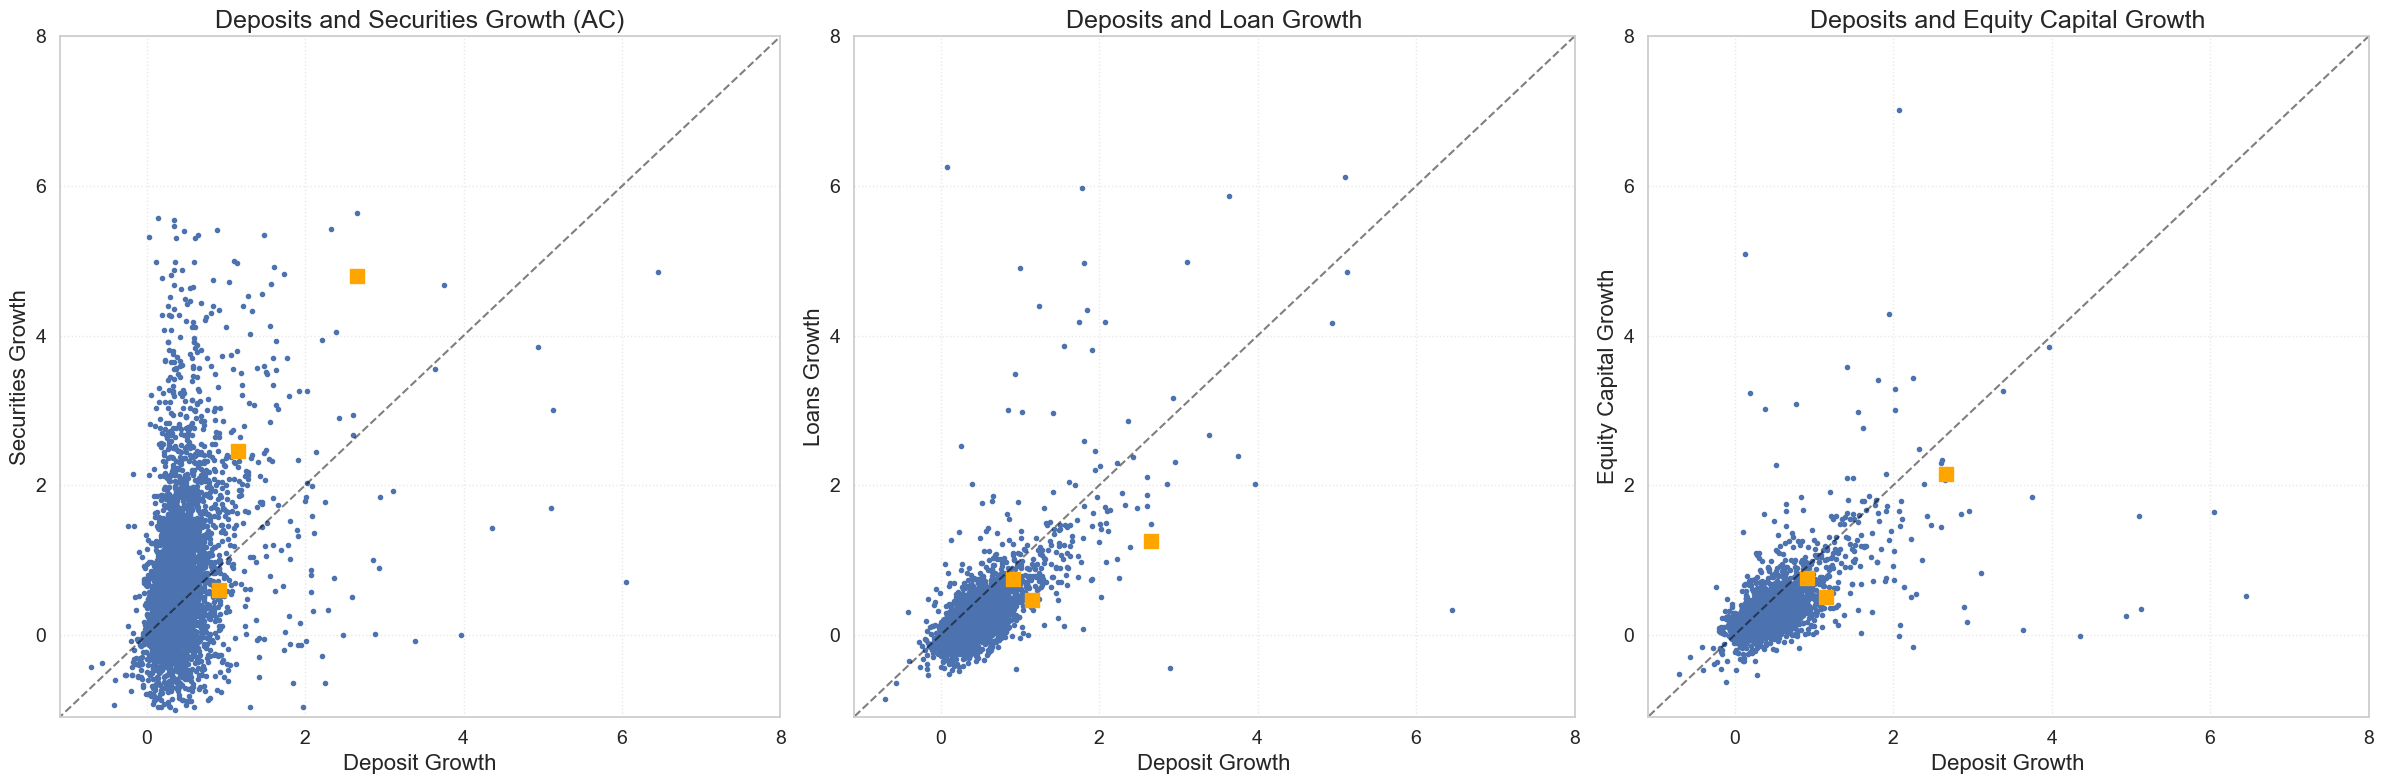

In [237]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Deposits Growth vs. Securities AC Growth
ax1.scatter(df2['Deposits Growth'], df2['Securities AC Growth'], marker='.')
ax1.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Securities AC Growth'],
            marker='s', s=100, color='orange')
ax1.set_xlabel('Deposit Growth', fontsize=16)
ax1.set_ylabel('Securities Growth', fontsize=16)
ax1.set_title('Deposits and Securities Growth (AC)', fontsize=18)
ax1.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks1 = ax1.get_yticks()
#ax1.set_xticks(ticks1)
lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
ax1.plot(lims1, lims1, linestyle='--', color='black', alpha=0.5)
ax1.set_xlim(-1.1, 8)
ax1.set_ylim(-1.1, 8)
ax1.tick_params(axis='both', labelsize=14)

# Plot 2: Deposits Growth vs. Loans Growth
ax2.scatter(df2['Deposits Growth'], df2['Loans Growth'], marker='.')
ax2.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Loans Growth'],
            marker='s', s=100, color='orange')
ax2.set_xlabel('Deposit Growth', fontsize=16)
ax2.set_ylabel('Loans Growth', fontsize=16)
ax2.set_title('Deposits and Loan Growth', fontsize=18)
ax2.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
ticks2 = ax2.get_yticks()
ax2.set_xticks(ticks2)
lims2 = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
         max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims2, lims2, linestyle='--', color='black', alpha=0.5)
ax2.set_xlim(-1.1, 8)
ax2.set_ylim(-1.1, 8)
ax2.tick_params(axis='both', labelsize=14)

# Plot 3: Deposits Growth vs. Equity Capital Growth
ax3.scatter(df2['Deposits Growth'], df2['Equity Capital Growth'], marker='.')
ax3.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Equity Capital Growth'],
            marker='s', s=100, color='orange')
ax3.set_xlabel('Deposit Growth', fontsize=16)
ax3.set_ylabel('Equity Capital Growth', fontsize=16)
ax3.set_title('Deposits and Equity Capital Growth', fontsize=18)
ax3.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
lims3 = [min(ax3.get_xlim()[0], ax3.get_ylim()[0]),
         max(ax3.get_xlim()[1], ax3.get_ylim()[1])]
ax3.plot(lims3, lims3, linestyle='--', color='black', alpha=0.5)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-1.1, 8)
ax3.set_ylim(-1.1, 8)
plt.tight_layout()
plt.show()

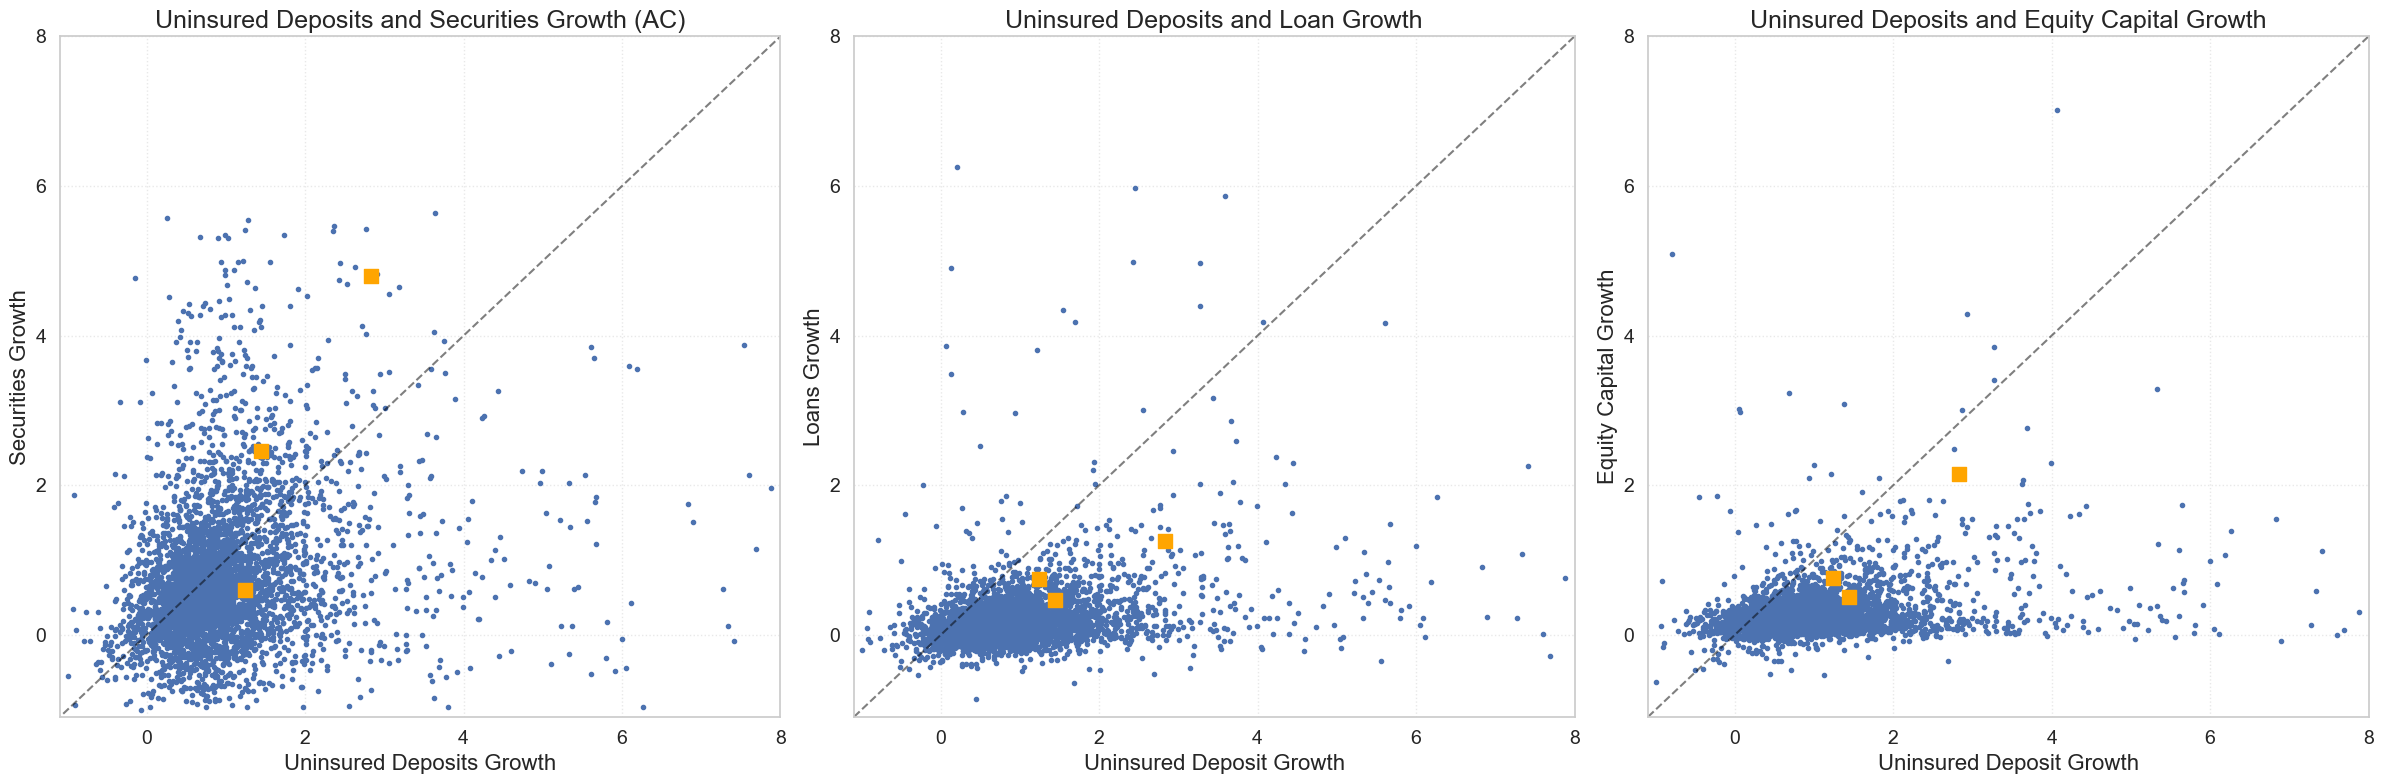

In [238]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Deposits Growth vs. Securities AC Growth
ax1.scatter(df2['Uninsured Deposits Growth'], df2['Securities AC Growth'], marker='.')
ax1.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Securities AC Growth'],
            marker='s', s=100, color='orange')
ax1.set_xlabel('Uninsured Deposits Growth', fontsize=16)
ax1.set_ylabel('Securities Growth', fontsize=16)
ax1.set_title('Uninsured Deposits and Securities Growth (AC)', fontsize=18)
ax1.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks1 = ax1.get_yticks()
#ax1.set_xticks(ticks1)
lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
         max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
ax1.plot(lims1, lims1, linestyle='--', color='black', alpha=0.5)
ax1.set_xlim(-1.1, 8)
ax1.set_ylim(-1.1, 8)
ax1.tick_params(axis='both', labelsize=14)

# Plot 2: Deposits Growth vs. Loans Growth
ax2.scatter(df2['Uninsured Deposits Growth'], df2['Loans Growth'], marker='.')
ax2.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Loans Growth'],
            marker='s', s=100, color='orange')
ax2.set_xlabel('Uninsured Deposit Growth', fontsize=16)
ax2.set_ylabel('Loans Growth', fontsize=16)
ax2.set_title('Uninsured Deposits and Loan Growth', fontsize=18)
ax2.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
ticks2 = ax2.get_yticks()
ax2.set_xticks(ticks2)
lims2 = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
         max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims2, lims2, linestyle='--', color='black', alpha=0.5)
ax2.set_xlim(-1.1, 8)
ax2.set_ylim(-1.1, 8)
ax2.tick_params(axis='both', labelsize=14)

# Plot 3: Deposits Growth vs. Equity Capital Growth
ax3.scatter(df2['Uninsured Deposits Growth'], df2['Equity Capital Growth'], marker='.')
ax3.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Equity Capital Growth'],
            marker='s', s=100, color='orange')
ax3.set_xlabel('Uninsured Deposit Growth', fontsize=16)
ax3.set_ylabel('Equity Capital Growth', fontsize=16)
ax3.set_title('Uninsured Deposits and Equity Capital Growth', fontsize=18)
ax3.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
lims3 = [min(ax3.get_xlim()[0], ax3.get_ylim()[0]),
         max(ax3.get_xlim()[1], ax3.get_ylim()[1])]
ax3.plot(lims3, lims3, linestyle='--', color='black', alpha=0.5)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-1.1, 8)
ax3.set_ylim(-1.1, 8)
plt.tight_layout()
plt.show()

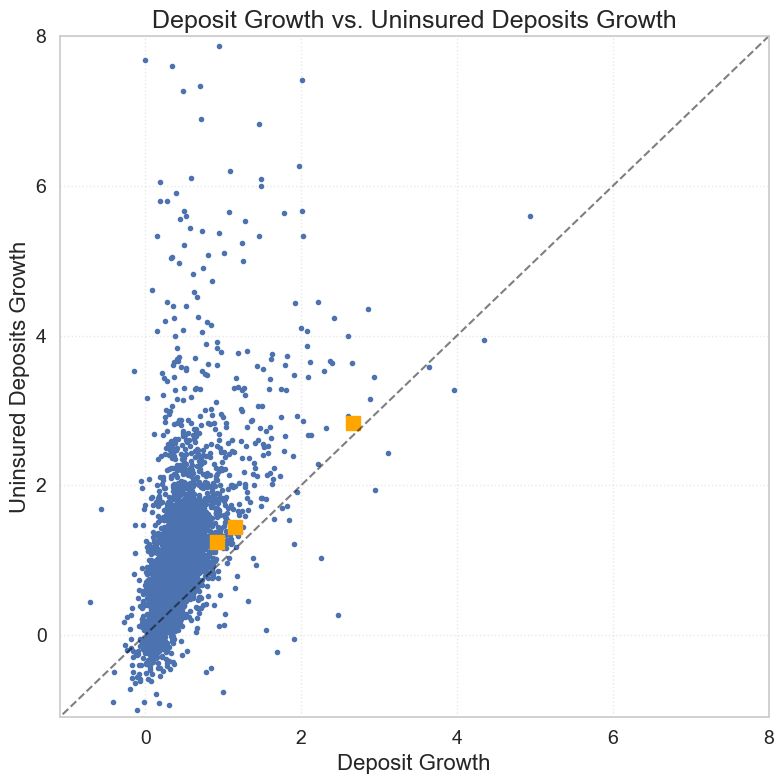

In [221]:
# make the same scatter plot with 'Deposit Growth' in the x-axis and 'Uninsured Deposits Growth' in the y-axis:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df2['Deposits Growth'], df2['Uninsured Deposits Growth'], marker='.')
ax.scatter(df2[df2['IDRSSD'].isin(failed_banks)]['Deposits Growth'],
            df2[df2['IDRSSD'].isin(failed_banks)]['Uninsured Deposits Growth'],
            marker='s', s=100, color='orange')
ax.set_xlabel('Deposit Growth', fontsize=16)
ax.set_ylabel('Uninsured Deposits Growth', fontsize=16)
ax.set_title('Deposit Growth vs. Uninsured Deposits Growth', fontsize=18)
ax.grid(color='lightgrey', ls=':', alpha=0.5, lw=1)
# Force similar tick spacing on both axes
#ticks = ax.get_yticks()
#ax.set_xticks(ticks)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, linestyle='--', color='black', alpha=0.5)
ax.set_xlim(-1.1, 8)
ax.set_ylim(-1.1, 8)
ax.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

### AOCI and MTM Losses

In [25]:
df_temp = main.copy()
#final_date = pd.Timestamp('2023-01-01')
final_date = df_temp['Date'].max()

df_temp['AOCI %'] = (df_temp['AOCI'] / df_temp['Total Assets']) * 100

# Assuming `main` is your constructed DataFrame
df_failed = df_temp[df_temp['IDRSSD'].isin(failed_banks)].copy()
df_failed = df_failed.sort_values(['Financial Institution Name', 'Date'])

In [26]:
# Prepare the data for plotting
df_other = df_temp[~df_temp['IDRSSD'].isin(failed_banks)].copy()

# Compute weighted average AOCI among other banks by total assets
weighted_avg = (
    df_other[['Date', 'AOCI %', 'Total Assets']]
    .groupby('Date')
    .apply(lambda x: (x['AOCI %'] * x['Total Assets']).sum() / x['Total Assets'].sum())
    .sort_index()
    .reset_index(name='AOCI %')
)

# Compute simple average AOCI among other banks
simple_avg = (
    df_other[['Date', 'AOCI %']]
    .groupby('Date')
    .mean()
    .sort_index()
    .reset_index()
)

C:\Users\angel\AppData\Local\Temp\ipykernel_5388\431990288.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['AOCI %'] * x['Total Assets']).sum() / x['Total Assets'].sum())


In [27]:
# compute the difference between 'Securities Booked' and 'Securities FV':
df_temp['MTM Losses HTM'] = -(df_temp['Securities Booked'] - df_temp['Securities FV'])
df_temp['MTM Losses %'] = 100*((df_temp['MTM Losses HTM']+df_temp['AOCI']) / df_temp['Total Assets'])
filtered_data = df_temp[(df_temp['Date'] >= pd.Timestamp('2015-01-01')) & 
                            (df_temp['Date'] <= final_date)]

In [28]:
# aggregate the MTM losses by date and plot using df_temp['Date'] as x-axis:
mtm_agg = df_temp.groupby('Date')['MTM Losses HTM'].sum().reset_index().sort_values('Date')


In [29]:
# rename MTM Losses to MTM Losses HTM:
mtm_agg['MTM Losses AFS'] = df_temp.groupby('Date')['AOCI'].sum().reset_index().sort_values('Date')['AOCI']


In [30]:
# multiply by 1000 to convert to billions:
mtm_agg['MTM Losses HTM'] = mtm_agg['MTM Losses HTM'] * 1000 / 1e9
mtm_agg['MTM Losses AFS'] = mtm_agg['MTM Losses AFS'] * 1000 / 1e9

In [31]:
#mtm_agg = mtm_agg[(mtm_agg['Date'] >= pd.Timestamp('2015-01-01')) & 
#                            (mtm_agg['Date'] <= final_date)]

In [32]:
# Separate the groups
failed_group = filtered_data[filtered_data['IDRSSD'].isin(failed_banks[0:-1])]

# Compute weighted average MTM Losses using Total Assets as weights
failed_weighted = (
    failed_group.groupby('Date')
    .apply(lambda x: np.average(x['MTM Losses %'], weights=x['Total Assets']))
    .reset_index(name='Weighted MTM Losses')
)

others_group = filtered_data[~filtered_data['IDRSSD'].isin(failed_banks[0:-1])].copy()
# Drop rows with missing or zero Total Assets
others_group = others_group.dropna(subset=['Total Assets', 'MTM Losses %'])
others_group = others_group[others_group['Total Assets'] != 0]

others_weighted = (
    others_group.groupby('Date')
    .apply(lambda x: np.average(x['MTM Losses %'], weights=x['Total Assets']) if x['Total Assets'].sum() != 0 else np.nan)
    .reset_index(name='Weighted MTM Losses')
)

C:\Users\angel\AppData\Local\Temp\ipykernel_5388\937492669.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['MTM Losses %'], weights=x['Total Assets']))
C:\Users\angel\AppData\Local\Temp\ipykernel_5388\937492669.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['MTM Losses %'], weights=x['Total Assets']) if x['Total Assets'].sum() != 0 else n

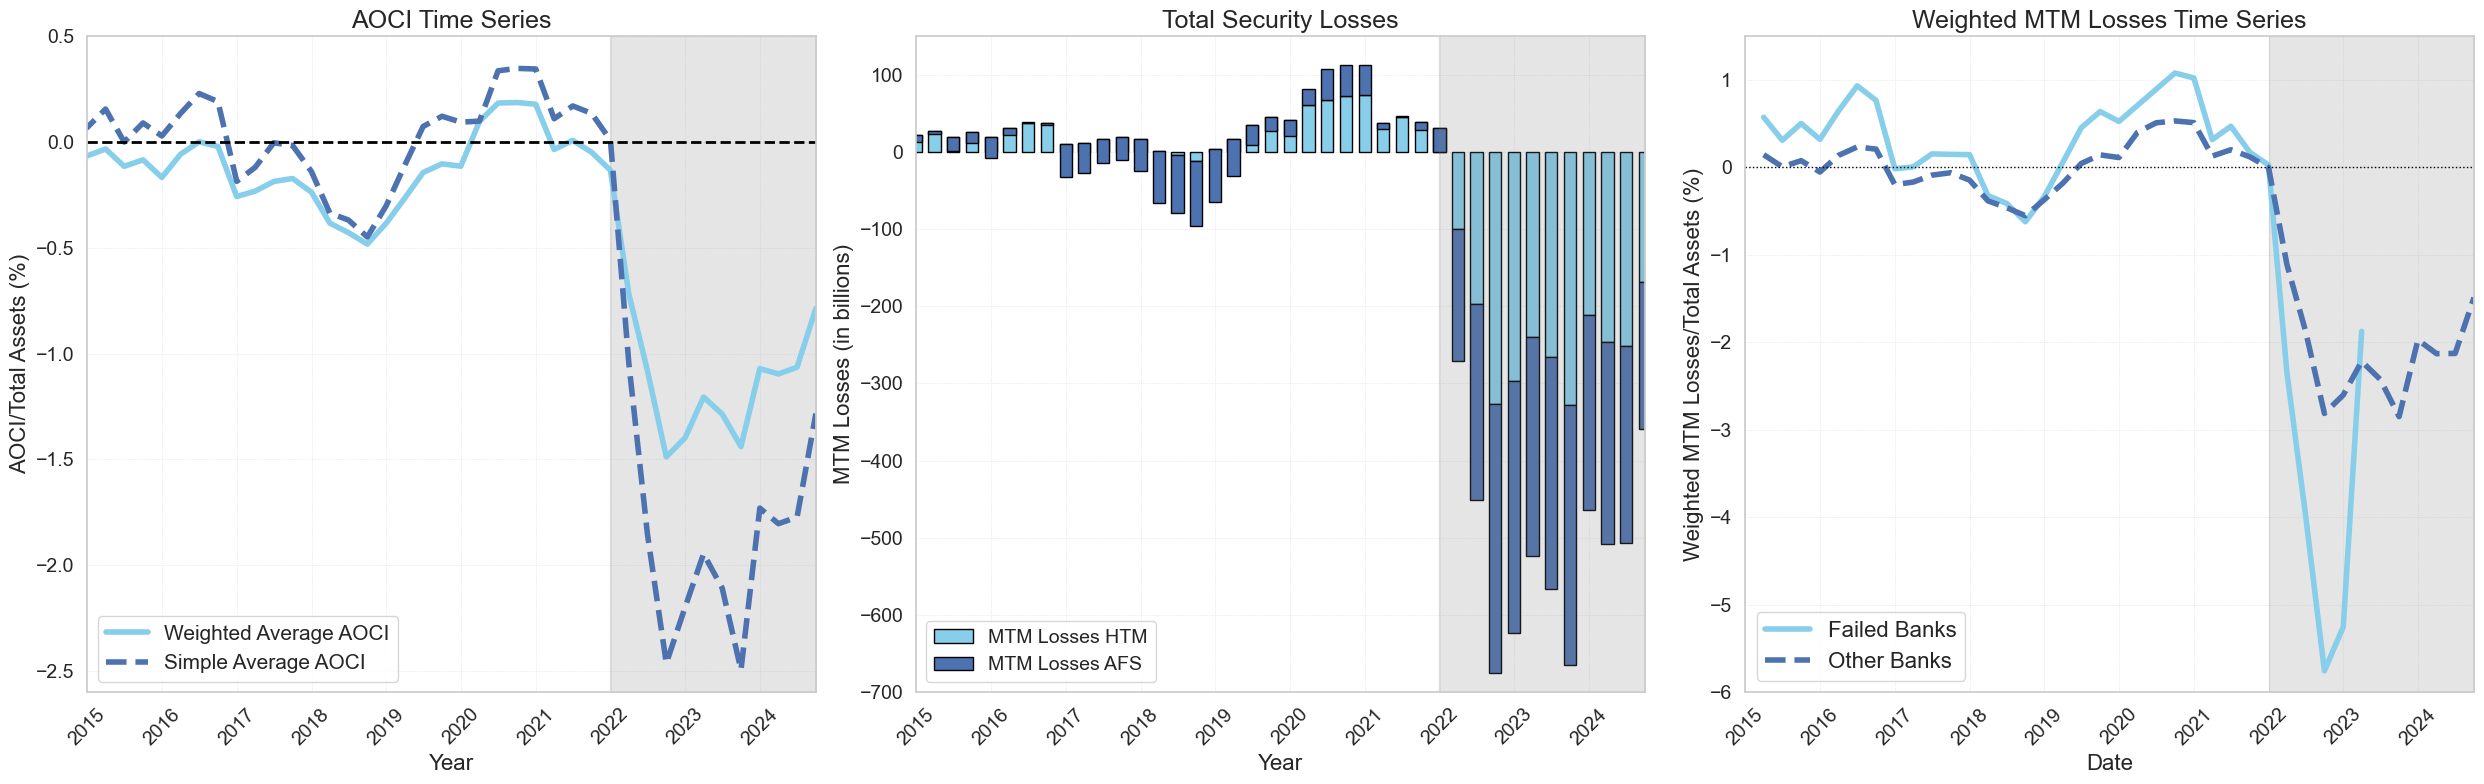

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
# ----------------------------------------------------------------------------------------------
# Plot 1: AOCI Time Series
sns.lineplot(ax=axes[0], data=weighted_avg, x='Date', y='AOCI %', 
             label='Weighted Average AOCI', linewidth=4, color='skyblue')
sns.lineplot(ax=axes[0], data=simple_avg, x='Date', y='AOCI %', 
             label='Simple Average AOCI', linewidth=4, linestyle='--')
axes[0].grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
axes[0].axhline(0, color='black', linestyle='--', linewidth=2)
axes[0].fill_betweenx(y=[-2.6, 0.5],
                      x1=pd.Timestamp('2021-12-31'),
                      x2=final_date,
                      color='grey', alpha=0.2)
axes[0].legend(fontsize=15, loc='lower left')
axes[0].set_xlabel('Year', fontsize=16)
axes[0].set_ylabel('AOCI/Total Assets (%)', fontsize=16)
axes[0].set_title('AOCI Time Series', fontsize=18)
axes[0].set_xlim(pd.Timestamp('2015-01-01'), final_date)
axes[0].set_ylim(-2.6, 0.5)
axes[0].tick_params(axis='x', labelsize=14, rotation=45)
axes[0].tick_params(axis='y', labelsize=14)
# ----------------------------------------------------------------------------------------------
# Plot 2: stacked barplot of MTM losses

# Define a thicker bar width
bar_width = 60  # adjust as needed

# Plot the first (bottom) bar: MTM Losses HTM using the same skyblue as in axes[0] and [2]
axes[1].bar(mtm_agg['Date'], mtm_agg['MTM Losses HTM'], 
            width=bar_width, color='skyblue', label='MTM Losses HTM', edgecolor='black')

# Plot the second bar on top: MTM Losses AFS using the default second palette color
axes[1].bar(mtm_agg['Date'], mtm_agg['MTM Losses AFS'], 
            width=bar_width, bottom=mtm_agg['MTM Losses HTM'], 
            label='MTM Losses AFS', edgecolor='black')

# Set title and labels directly on axes[1]
axes[1].set_title('Total Security Losses', fontsize=18)
axes[1].set_xlabel('Year', fontsize=16)
axes[1].set_ylabel('MTM Losses (in billions)', fontsize=16)

# Configure x-axis to show only years
axes[1].tick_params(axis='x', labelsize=14, rotation=45)
axes[1].fill_betweenx(y=[-800, 200],
                      x1=pd.Timestamp('2021-12-31'),
                      x2=final_date,
                      color='grey', alpha=0.2)
axes[1].legend(fontsize=14, loc='lower left')
axes[1].grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
axes[1].set_xlim(pd.Timestamp('2015-01-01'), final_date)
axes[1].set_ylim(-700, 150)
axes[1].tick_params(axis='y', labelsize=14)



# ----------------------------------------------------------------------------------------------
# Plot 3: Weighted MTM Losses
sns.lineplot(ax=axes[2], data=failed_weighted, x='Date', y='Weighted MTM Losses',
             lw=4, ci=False, color='skyblue', label='Failed Banks')
sns.lineplot(ax=axes[2], data=others_weighted, x='Date', y='Weighted MTM Losses',
             lw=4, ci=False, linestyle='--', label='Other Banks')
axes[2].axhline(0, lw=1, ls=':', color='black')
axes[2].legend(loc='lower left', fontsize=16)
axes[2].grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
axes[2].fill_betweenx(y=[-6, 1.5],
                      x1=pd.Timestamp('2021-12-31'),
                      x2=final_date,
                      color='grey', alpha=0.2)
axes[2].set_xlabel('Date', fontsize=16)
axes[2].set_ylabel('Weighted MTM Losses/Total Assets (%)', fontsize=16)
axes[2].set_title('Weighted MTM Losses Time Series', fontsize=18)
axes[2].set_xlim(pd.Timestamp('2015-01-01'), final_date)
axes[2].set_ylim(-6, 1.5)
axes[2].tick_params(axis='x', labelsize=14, rotation=45)
axes[2].tick_params(axis='y', labelsize=14)
# ----------------------------------------------------------------------------------------------
plt.tight_layout()
plt.show()

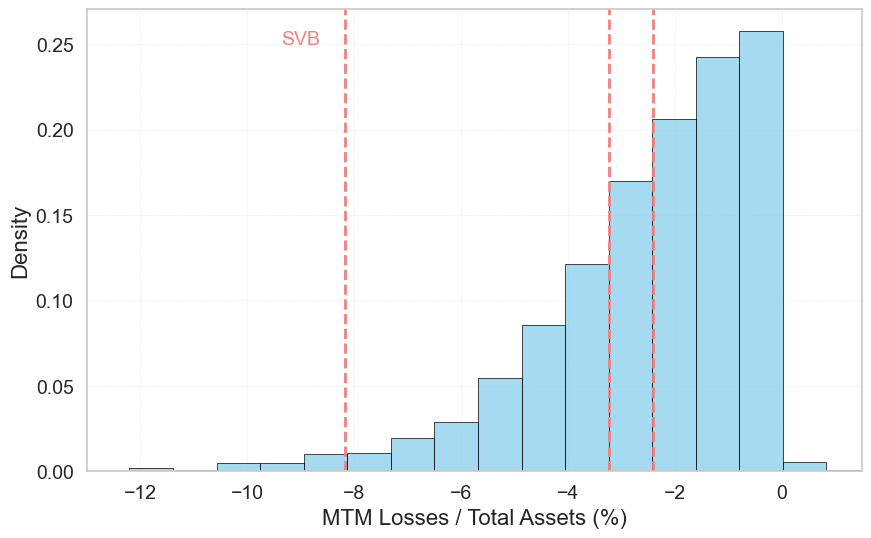

In [34]:
# Get the last available date in 2022
last_date = '2022-12-31'  # Assuming the last date is December 31, 2022

# Select rows corresponding to this last date
data_last = df_temp[df_temp['Date'] == last_date].copy()

# Compute a weighted version of MTM Losses for each bank:
#total_assets_last = data_last['Total Assets'].sum()
#data_last['Weighted MTM Losses'] = data_last['MTM Losses %'] * (data_last['Total Assets'] / total_assets_last)


# Plot the distribution of 'AOCI %'
plt.figure(figsize=(10, 6))
sns.histplot(data=data_last, x='MTM Losses %', bins=30, kde=False, color='skyblue', 
             stat='density', edgecolor='black', linewidth=0.5)
# place a vertical line at SVB's MTM Losses %:
svb_mtm_loss = data_last[data_last['IDRSSD'] == 802866]['MTM Losses %'].values[0]
plt.axvline(svb_mtm_loss, color='lightcoral', linestyle='--', linewidth=2, label='SVB')
# write 'SVB' next to the vertical line:
plt.text(svb_mtm_loss - 1.2, 0.25, 'SVB', color='lightcoral', fontsize=14)
# place a vertical line at Signature Bank's MTM Losses %:
sig_mtm_loss = data_last[data_last['IDRSSD'] == 3437483]['MTM Losses %'].values[0]
plt.axvline(sig_mtm_loss, color='lightcoral', linestyle='--', linewidth=2, label='Signature Bank')
# place a vertical line at First Republic's MTM Losses %:
frb_mtm_loss = data_last[data_last['IDRSSD'] == 4114567]['MTM Losses %'].values[0]
plt.axvline(frb_mtm_loss, color='lightcoral', linestyle='--', linewidth=2, label='First Republic')
#plt.title('Distribution of MTM Losses/Total Assets (%)', fontsize=18)
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7, color='lightgrey')
plt.xlabel('MTM Losses / Total Assets (%)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xlim(-13, 1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()